In [27]:
# cfg = stuf({'experiment_type':'A+B_train_val_test',
#             'dataset_A':'Leaves',
#             'dataset_B':'Fossil'})

cfg = stuf({'experiment_type':'A+B_train_val_test',
            'dataset_A':'PNAS',
            'dataset_B':'Fossil'})

cfg = stuf({'experiment_type':'A+B_train_val_test',
            'dataset_A':'Fossil',
            'dataset_B':'PNAS'})


runs_table = experiments_db.get_db_table('runs',EXPERIMENTS_DB)

run_id = select_by_multicol(runs_table, kwargs={'experiment_type':cfg.experiment_type,
                                                    'dataset_A':cfg.dataset_A,
                                                    'dataset_B':cfg.dataset_B})['run_id'].tolist()#iloc[0]
print(f'run_id = {run_id}')
if len(run_id)==0:
    run_id = select_by_multicol(runs_table, kwargs={'experiment_type':cfg.experiment_type,
                                                        'dataset_A':cfg.dataset_B,
                                                        'dataset_B':cfg.dataset_A})['run_id'].tolist()#.values#.iloc[0]
    if len(run_id)==0:
        print('invalid dataset_A or dataset_B, experiment config info not found')
        raise
    else:
        print('Reversing order of provided datasets from A,B to B,A. This should make no difference based on experiment type.')
        cfg.dataset_A, cfg.dataset_B = cfg.dataset_B, cfg.dataset_A
    
cfg.run_id = run_id
pprint(cfg)
# pprint(cfg.run_id.iloc[0])

run_id = []
Reversing order of provided datasets from A,B to B,A. This should make no difference based on experiment type.
{'dataset_A': 'PNAS',
 'dataset_B': 'Fossil',
 'experiment_type': 'A+B_train_val_test',
 'run_id': ['2000']}


In [8]:
runs_table

,run_id,experiment_type,dataset_A,dataset_B
0,1000,A_train_val_test,PNAS,None
1,1100,A_train_val_test,Fossil,None
2,1200,A_train_val_test,Leaves,None
3,2000,A+B_train_val_test,PNAS,Fossil
4,2100,A+B_train_val_test,PNAS,Leaves
5,2200,A+B_train_val_test,Fossil,Leaves
6,3000,A_train_val-B_train_val_test,PNAS,Fossil
7,3100,A_train_val-B_train_val_test,PNAS,Leaves
8,3200,A_train_val-B_train_val_test,Fossil,Leaves
9,4000,A+B_leave_one_out,PNAS,Fossil


In [1]:
gpu = 7
seed = 12321
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
print('os.environ["CUDA_VISIBLE_DEVICES"] : ',os.environ["CUDA_VISIBLE_DEVICES"])
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from pyleaves.leavesdb import experiments_db, db_manager
from pyleaves.leavesdb.experiments_db import DataBase, Table, TFRecordsTable, EXPERIMENTS_SCHEMA, TFRecordItem, EXPERIMENTS_DB
from pyleaves.leavesdb.experiments_db import get_db_table, select_by_col, select_by_multicol
from more_itertools import unzip
from functools import partial
import pandas as pd
import pyleaves
# from pyleaves import leavesdb
from pyleaves.configs.config_v2 import BaseConfig
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset
from pyleaves.utils.csv_utils import save_csv_data, load_csv_data
from pyleaves.utils.utils import ensure_dir_exists
from pyleaves.leavesdb.tf_utils.create_tfrecords import save_tfrecords
import random
from stuf import stuf
import time
from pprint import pprint


tables = experiments_db.get_db_contents()
experiment_view = select_by_col(table=tables['runs'],column='experiment_type',value='A+B_train_val_test')
experiment_view

os.environ["CUDA_VISIBLE_DEVICES"] :  7
OpenCV is built with OpenMP support. This usually results in poor performance. For details, see https://github.com/tensorpack/benchmarks/blob/master/ImageNet/benchmark-opencv-resize.py



,run_id,experiment_type,dataset_A,dataset_B
3,2000,A+B_train_val_test,PNAS,Fossil
4,2100,A+B_train_val_test,PNAS,Leaves
5,2200,A+B_train_val_test,Fossil,Leaves


In [28]:
tables = experiments_db.get_db_contents()
experiment_view = select_by_col(table=tables['tfrecords'],column='experiment_type',value='A+B_train_val_test')
experiment_view

,file_path,file_group,dataset_stage,subrun_id,run_id,experiment_type,dataset_name,resolution,num_channels,num_classes,num_shards,num_samples
97,/media/data/jacob/Fossil_Project/data/tfrecord...,train,dataset_A+dataset_B,2000,2000,A+B_train_val_test,PNAS+Fossil,256,3,37,10,456
98,/media/data/jacob/Fossil_Project/data/tfrecord...,train,dataset_A+dataset_B,2000,2000,A+B_train_val_test,PNAS+Fossil,256,3,37,10,456
99,/media/data/jacob/Fossil_Project/data/tfrecord...,train,dataset_A+dataset_B,2000,2000,A+B_train_val_test,PNAS+Fossil,256,3,37,10,456
100,/media/data/jacob/Fossil_Project/data/tfrecord...,train,dataset_A+dataset_B,2000,2000,A+B_train_val_test,PNAS+Fossil,256,3,37,10,456
101,/media/data/jacob/Fossil_Project/data/tfrecord...,train,dataset_A+dataset_B,2000,2000,A+B_train_val_test,PNAS+Fossil,256,3,37,10,456
...,...,...,...,...,...,...,...,...,...,...,...,...
191,/media/data/jacob/Fossil_Project/data/tfrecord...,test,dataset_A+dataset_B,2200,2200,A+B_train_val_test,Fossil+Leaves,256,3,380,10,1620
192,/media/data/jacob/Fossil_Project/data/tfrecord...,test,dataset_A+dataset_B,2200,2200,A+B_train_val_test,Fossil+Leaves,256,3,380,10,1620
193,/media/data/jacob/Fossil_Project/data/tfrecord...,test,dataset_A+dataset_B,2200,2200,A+B_train_val_test,Fossil+Leaves,256,3,380,10,1620
194,/media/data/jacob/Fossil_Project/data/tfrecord...,test,dataset_A+dataset_B,2200,2200,A+B_train_val_test,Fossil+Leaves,256,3,380,10,1620


In [5]:
data_src_db = r'/home/jacob/projects/wilf_data_updates/leavesdb.db'
include_runs = ['2100','2200']

start = time.time()

datasets = {
        'PNAS': pnas_dataset.PNASDataset(src_db=data_src_db),
        'Leaves': leaves_dataset.LeavesDataset(src_db=data_src_db),
        'Fossil': fossil_dataset.FossilDataset(src_db=data_src_db)
        }


logger = stuf({})
for i, run in experiment_view.iterrows():
#     break
    

    run_config = stuf(run.to_dict())

    if include_runs != ['all'] and (run_config['run_id'] not in include_runs):
        print(f"SKIPPING run with run_id={run_config['run_id']}")
        continue

    print('BEGINNING ', run)
    config = BaseConfig().parse(namespace=run_config)
    data_config_AB = config.data_config.dataset_AB
    log_name = data_config_AB.name
    logger[log_name] = stuf({})

    tfrecords_table = TFRecordsTable(db_path=config.user_config.experiments_db)
    num_shards = data_config_AB.num_shards
    resolution = data_config_AB.resolution

    names = config.datasets


    data_A = datasets[names[0]]
    data_B = datasets[names[1]]

    data_AB = data_A + data_B

    print('A:',data_A)
    print('B:',data_B)
    print('A+B:',data_AB)

    encoder = base_dataset.LabelEncoder(data_AB.data.family)
    ensure_dir_exists(data_config_AB.csv_dir)
    num_classes = data_config_AB.num_classes = encoder.num_classes

    processed = base_dataset.preprocess_data(data_AB, encoder, data_config_AB)

    print('A+B:',data_AB)

    for subset in processed.keys():
        Item = partial(TFRecordItem,**{
                            'run_id':run_config['run_id'],
                            'experiment_type':run_config['experiment_type'],
                            'file_group':subset,
                            'dataset_stage':'dataset_A+dataset_B',
                            'dataset_name':data_config_AB.name,
                            'resolution':resolution,
                            'num_channels':3,
                            'num_classes':num_classes,
                            'num_shards':num_shards
                            })

        random.shuffle(processed[subset])

        x, y = [list(i) for i in unzip(processed[subset])]
        save_csv_data(x, y, filepath = data_config_AB.csv_data[subset])
        encoder.save_config(data_config_AB.label_dir)

        logger[log_name][subset] = stuf({'start':time.time()})
        file_log = save_tfrecords(data=processed[subset],
                       output_dir=data_config_AB.tfrecord_dir,
                       file_prefix=subset,
                       target_size=(resolution, resolution),
                       num_channels=3,
                       num_classes=encoder.num_classes,
                       num_shards=num_shards,
                       TFRecordItem_factory=Item,
                       tfrecords_table=tfrecords_table,
                       verbose=True)

        logger[log_name][subset].end = time.time()
        logger[log_name][subset].total = logger[log_name][subset].end - logger[log_name][subset].start
        print(log_name, subset, f'took {logger[log_name][subset].total:.2f} sec to collect/convert to TFRecords')
    print(f'Full experiment took a total of {time.time()-start}')


SKIPPING run with run_id=2000
BEGINNING  run_id                           2100
experiment_type    A+B_train_val_test
dataset_A                        PNAS
dataset_B                      Leaves
Name: 4, dtype: object
A: PNAS:
    num_samples: 5314
    num_classes: 19
    class_count_threshold: 0
        
B: Leaves:
    num_samples: 26953
    num_classes: 376
    class_count_threshold: 0
        
A+B: PNAS+Leaves:
    num_samples: 32267
    num_classes: 376
    class_count_threshold: 0
        
train 0.4 (0, 12635)
val 0.1 (12635, 15794)
test 0.5 (15794, 31589)
A+B: PNAS+Leaves:
    num_samples: 31589
    num_classes: 190
    class_count_threshold: 10
        
saved 12635 samples to /media/data_cifs/jacob/Fossil_Project/data/csv_data/A+B_train_val_test/PNAS+Leaves/train_data.csv
Starting to split train subset with 12635 total samples into 10 shards
converting 12635 images to tfrecord
self.num_shards 10


  3%|▎         | 33/1263 [00:00<00:03, 321.34it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00000-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 313.13it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00000-of-00010.tfrecord
Wrote 1263 in 4.04


  3%|▎         | 32/1263 [00:00<00:03, 317.92it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00001-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 315.55it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00001-of-00010.tfrecord
Wrote 1263 in 4.01


  3%|▎         | 34/1263 [00:00<00:03, 334.16it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00002-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 310.95it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00002-of-00010.tfrecord
Wrote 1263 in 4.07


  3%|▎         | 34/1263 [00:00<00:03, 331.67it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00003-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 314.75it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00003-of-00010.tfrecord
Wrote 1263 in 4.02


  3%|▎         | 33/1263 [00:00<00:03, 329.20it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00004-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 312.16it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00004-of-00010.tfrecord
Wrote 1263 in 4.05


  2%|▏         | 31/1263 [00:00<00:03, 308.94it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00005-of-00010.tfrecord


100%|██████████| 1263/1263 [00:03<00:00, 316.44it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00005-of-00010.tfrecord
Wrote 1263 in 4.00


  2%|▏         | 31/1263 [00:00<00:03, 309.82it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00006-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 306.29it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00006-of-00010.tfrecord
Wrote 1263 in 4.13


  3%|▎         | 33/1263 [00:00<00:03, 328.41it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00007-of-00010.tfrecord


100%|██████████| 1263/1263 [00:04<00:00, 314.98it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00007-of-00010.tfrecord
Wrote 1263 in 4.01


  3%|▎         | 33/1263 [00:00<00:03, 320.87it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00008-of-00010.tfrecord


100%|██████████| 1263/1263 [00:03<00:00, 318.56it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00008-of-00010.tfrecord
Wrote 1263 in 3.99


  3%|▎         | 34/1263 [00:00<00:03, 334.75it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00009-of-00010.tfrecord


100%|██████████| 5/5 [00:00<00:00, 306.39it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00009-of-00010.tfrecord
Wrote 1263 in 3.96
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/train-00010-of-00010.tfrecord
Wrote 5 in 0.03
PNAS+Leaves train took 774.34 sec to collect/convert to TFRecords
saved 3159 samples to /media/data_cifs/jacob/Fossil_Project/data/csv_data/A+B_train_val_test/PNAS+Leaves/val_data.csv
Starting to split val subset with 3159 total samples into 10 shards
converting 3159 images to tfrecord
self.num_shards 10


 10%|▉         | 31/315 [00:00<00:00, 301.53it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00000-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 296.54it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00000-of-00010.tfrecord
Wrote 315 in 1.07


 10%|█         | 32/315 [00:00<00:00, 312.51it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00001-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 312.64it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00001-of-00010.tfrecord
Wrote 315 in 1.01


 10%|█         | 33/315 [00:00<00:00, 329.28it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00002-of-00010.tfrecord


100%|██████████| 315/315 [00:00<00:00, 324.94it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00002-of-00010.tfrecord
Wrote 315 in 0.97


 10%|█         | 33/315 [00:00<00:00, 320.73it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00003-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 311.89it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00003-of-00010.tfrecord
Wrote 315 in 1.02


 10%|█         | 32/315 [00:00<00:00, 319.98it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00004-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 314.66it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00004-of-00010.tfrecord
Wrote 315 in 1.01


 10%|█         | 33/315 [00:00<00:00, 325.26it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00005-of-00010.tfrecord


100%|██████████| 315/315 [00:00<00:00, 316.95it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00005-of-00010.tfrecord
Wrote 315 in 1.00


 10%|█         | 32/315 [00:00<00:00, 317.28it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00006-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 310.54it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00006-of-00010.tfrecord
Wrote 315 in 1.02


 10%|▉         | 31/315 [00:00<00:00, 301.08it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00007-of-00010.tfrecord


100%|██████████| 315/315 [00:00<00:00, 315.33it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00007-of-00010.tfrecord
Wrote 315 in 1.00


 10%|▉         | 31/315 [00:00<00:00, 306.91it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00008-of-00010.tfrecord


100%|██████████| 315/315 [00:01<00:00, 308.29it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00008-of-00010.tfrecord
Wrote 315 in 1.04


 11%|█         | 34/315 [00:00<00:00, 330.10it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00009-of-00010.tfrecord


100%|██████████| 9/9 [00:00<00:00, 313.42it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00009-of-00010.tfrecord
Wrote 315 in 0.99
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/val-00010-of-00010.tfrecord
Wrote 9 in 0.03
PNAS+Leaves val took 195.74 sec to collect/convert to TFRecords
saved 15795 samples to /media/data_cifs/jacob/Fossil_Project/data/csv_data/A+B_train_val_test/PNAS+Leaves/test_data.csv
Starting to split test subset with 15795 total samples into 10 shards
converting 15795 images to tfrecord
self.num_shards 10


  2%|▏         | 32/1579 [00:00<00:04, 317.16it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00000-of-00010.tfrecord


100%|██████████| 1579/1579 [00:05<00:00, 312.82it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00000-of-00010.tfrecord
Wrote 1579 in 5.06


  2%|▏         | 33/1579 [00:00<00:04, 324.28it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00001-of-00010.tfrecord


100%|██████████| 1579/1579 [00:05<00:00, 315.00it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00001-of-00010.tfrecord
Wrote 1579 in 5.02


  2%|▏         | 28/1579 [00:00<00:05, 277.21it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00002-of-00010.tfrecord


100%|██████████| 1579/1579 [00:05<00:00, 309.24it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00002-of-00010.tfrecord
Wrote 1579 in 5.11


  2%|▏         | 30/1579 [00:00<00:05, 299.96it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00003-of-00010.tfrecord


100%|██████████| 1579/1579 [00:05<00:00, 313.43it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00003-of-00010.tfrecord
Wrote 1579 in 5.04


  2%|▏         | 33/1579 [00:00<00:04, 329.40it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00004-of-00010.tfrecord


100%|██████████| 1579/1579 [00:05<00:00, 313.63it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00004-of-00010.tfrecord
Wrote 1579 in 5.04


  2%|▏         | 33/1579 [00:00<00:04, 322.27it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00005-of-00010.tfrecord


100%|██████████| 1579/1579 [00:04<00:00, 315.86it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00005-of-00010.tfrecord
Wrote 1579 in 5.00


  2%|▏         | 33/1579 [00:00<00:04, 324.61it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00006-of-00010.tfrecord


100%|██████████| 1579/1579 [00:04<00:00, 316.80it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00006-of-00010.tfrecord
Wrote 1579 in 4.99


  2%|▏         | 32/1579 [00:00<00:04, 319.21it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00007-of-00010.tfrecord


100%|██████████| 1579/1579 [00:04<00:00, 318.65it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00007-of-00010.tfrecord
Wrote 1579 in 4.96


  2%|▏         | 33/1579 [00:00<00:04, 318.60it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00008-of-00010.tfrecord


100%|██████████| 1579/1579 [00:04<00:00, 320.57it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00008-of-00010.tfrecord
Wrote 1579 in 4.94


  2%|▏         | 32/1579 [00:00<00:04, 314.91it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00009-of-00010.tfrecord


100%|██████████| 5/5 [00:00<00:00, 247.69it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00009-of-00010.tfrecord
Wrote 1579 in 4.97
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/PNAS+Leaves/test-00010-of-00010.tfrecord
Wrote 5 in 0.02
PNAS+Leaves test took 1063.83 sec to collect/convert to TFRecords
Full experiment took a total of 2037.7148036956787
BEGINNING  run_id                           2200
experiment_type    A+B_train_val_test
dataset_A                      Fossil
dataset_B                      Leaves
Name: 5, dtype: object
A: Fossil:
    num_samples: 6122
    num_classes: 27
    class_count_threshold: 0
        
B: Leaves:
    num_samples: 26953
    num_classes: 376
    class_count_threshold: 0
        
A+B: Fossil+Leaves:
    num_samples: 33075
    num_classes: 380
    class_count_thre

  3%|▎         | 34/1296 [00:00<00:03, 333.40it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00000-of-00010.tfrecord


100%|██████████| 1296/1296 [00:04<00:00, 312.37it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00000-of-00010.tfrecord
Wrote 1296 in 4.16


  2%|▏         | 22/1296 [00:00<00:08, 158.15it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00001-of-00010.tfrecord


100%|██████████| 1296/1296 [00:04<00:00, 318.36it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00001-of-00010.tfrecord
Wrote 1296 in 4.08


  3%|▎         | 34/1296 [00:00<00:03, 337.48it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00002-of-00010.tfrecord


100%|██████████| 1296/1296 [00:03<00:00, 325.68it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00002-of-00010.tfrecord
Wrote 1296 in 3.99


  3%|▎         | 34/1296 [00:00<00:03, 331.01it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00003-of-00010.tfrecord


100%|██████████| 1296/1296 [00:03<00:00, 326.75it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00003-of-00010.tfrecord
Wrote 1296 in 3.97


  3%|▎         | 33/1296 [00:00<00:03, 327.61it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00004-of-00010.tfrecord


100%|██████████| 1296/1296 [00:04<00:00, 320.44it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00004-of-00010.tfrecord
Wrote 1296 in 4.05


  2%|▏         | 31/1296 [00:00<00:04, 309.11it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00005-of-00010.tfrecord


100%|██████████| 1296/1296 [00:04<00:00, 317.93it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00005-of-00010.tfrecord
Wrote 1296 in 4.08


  3%|▎         | 35/1296 [00:00<00:03, 342.47it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00006-of-00010.tfrecord


100%|██████████| 1296/1296 [00:03<00:00, 327.55it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00006-of-00010.tfrecord
Wrote 1296 in 3.96


  3%|▎         | 33/1296 [00:00<00:03, 321.83it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00007-of-00010.tfrecord


100%|██████████| 1296/1296 [00:03<00:00, 324.83it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00007-of-00010.tfrecord
Wrote 1296 in 4.00


  2%|▏         | 32/1296 [00:00<00:03, 318.32it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00008-of-00010.tfrecord


100%|██████████| 1296/1296 [00:04<00:00, 319.78it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00008-of-00010.tfrecord
Wrote 1296 in 4.07


  3%|▎         | 33/1296 [00:00<00:03, 325.92it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00009-of-00010.tfrecord


100%|██████████| 3/3 [00:00<00:00, 229.72it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00009-of-00010.tfrecord
Wrote 1296 in 3.94
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/train-00010-of-00010.tfrecord
Wrote 3 in 0.02
Fossil+Leaves train took 933.70 sec to collect/convert to TFRecords
saved 3241 samples to /media/data_cifs/jacob/Fossil_Project/data/csv_data/A+B_train_val_test/Fossil+Leaves/val_data.csv
Starting to split val subset with 3241 total samples into 10 shards
converting 3241 images to tfrecord
self.num_shards 10


 10%|█         | 34/324 [00:00<00:00, 335.73it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00000-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 325.92it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00000-of-00010.tfrecord
Wrote 324 in 1.00


 10%|█         | 34/324 [00:00<00:00, 337.70it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00001-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 337.52it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00001-of-00010.tfrecord
Wrote 324 in 0.96


 10%|█         | 34/324 [00:00<00:00, 332.78it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00002-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 329.46it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00002-of-00010.tfrecord
Wrote 324 in 0.99


 10%|█         | 34/324 [00:00<00:00, 331.49it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00003-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 324.67it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00003-of-00010.tfrecord
Wrote 324 in 1.00


  9%|▉         | 30/324 [00:00<00:00, 296.43it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00004-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 326.53it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00004-of-00010.tfrecord
Wrote 324 in 1.00


 10%|█         | 34/324 [00:00<00:00, 333.99it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00005-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 337.27it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00005-of-00010.tfrecord
Wrote 324 in 0.98


 10%|█         | 34/324 [00:00<00:00, 331.51it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00006-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 330.08it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00006-of-00010.tfrecord
Wrote 324 in 0.99


 11%|█         | 36/324 [00:00<00:00, 359.95it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00007-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 342.62it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00007-of-00010.tfrecord
Wrote 324 in 0.95


 10%|█         | 33/324 [00:00<00:00, 329.73it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00008-of-00010.tfrecord


100%|██████████| 324/324 [00:00<00:00, 325.56it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00008-of-00010.tfrecord
Wrote 324 in 1.00


 10%|█         | 34/324 [00:00<00:00, 332.35it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00009-of-00010.tfrecord


100%|██████████| 1/1 [00:00<00:00, 266.14it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00009-of-00010.tfrecord
Wrote 324 in 1.01
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/val-00010-of-00010.tfrecord
Wrote 1 in 0.01
Fossil+Leaves val took 265.47 sec to collect/convert to TFRecords
saved 16205 samples to /media/data_cifs/jacob/Fossil_Project/data/csv_data/A+B_train_val_test/Fossil+Leaves/test_data.csv
Starting to split test subset with 16205 total samples into 10 shards
converting 16205 images to tfrecord
self.num_shards 10


  2%|▏         | 35/1620 [00:00<00:04, 341.90it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00000-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 320.34it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00000-of-00010.tfrecord
Wrote 1620 in 5.06


  2%|▏         | 33/1620 [00:00<00:04, 323.18it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00001-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 321.79it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00001-of-00010.tfrecord
Wrote 1620 in 5.04


  2%|▏         | 33/1620 [00:00<00:04, 325.08it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00002-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 302.79it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00002-of-00010.tfrecord
Wrote 1620 in 5.36


  2%|▏         | 32/1620 [00:00<00:04, 319.62it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00003-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 295.57it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00003-of-00010.tfrecord
Wrote 1620 in 5.49


  2%|▏         | 34/1620 [00:00<00:04, 334.08it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00004-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 304.11it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00004-of-00010.tfrecord
Wrote 1620 in 5.33


  2%|▏         | 34/1620 [00:00<00:04, 333.33it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00005-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 310.39it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00005-of-00010.tfrecord
Wrote 1620 in 5.22


  2%|▏         | 33/1620 [00:00<00:04, 323.82it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00006-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 306.48it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00006-of-00010.tfrecord
Wrote 1620 in 5.30


  2%|▏         | 33/1620 [00:00<00:04, 323.79it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00007-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 303.56it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00007-of-00010.tfrecord
Wrote 1620 in 5.34


  2%|▏         | 32/1620 [00:00<00:05, 316.48it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00008-of-00010.tfrecord


100%|██████████| 1620/1620 [00:05<00:00, 299.10it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00008-of-00010.tfrecord
Wrote 1620 in 5.42


  2%|▏         | 33/1620 [00:00<00:04, 328.94it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00009-of-00010.tfrecord


100%|██████████| 5/5 [00:00<00:00, 314.40it/s]

Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00009-of-00010.tfrecord
Wrote 1620 in 5.34
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A+B_train_val_test/Fossil+Leaves/test-00010-of-00010.tfrecord
Wrote 5 in 0.02
Fossil+Leaves test took 1578.72 sec to collect/convert to TFRecords
Full experiment took a total of 4817.970103263855


In [1]:
#This is for scratch work developing the main training pipeline

import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from stuf import stuf
import os

gpu = 7
seed = 12321
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu)
print('os.environ["CUDA_VISIBLE_DEVICES"] : ',os.environ["CUDA_VISIBLE_DEVICES"])

import tensorflow as tf
tf.compat.v1.enable_eager_execution()


from pyleaves.leavesdb.tf_utils.tf_utils import set_random_seed, reset_keras_session
set_random_seed(seed)
reset_keras_session()


import pyleaves
# from pyleaves import leavesdb
from pyleaves.base.base_data_manager import DataManager
from pyleaves.base.base_trainer import ModelBuilder, BaseTrainer
from pyleaves.configs.config_v2 import BaseConfig
from pyleaves.leavesdb import experiments_db, db_manager
from pyleaves.leavesdb.experiments_db import DataBase, Table, TFRecordsTable, EXPERIMENTS_SCHEMA, TFRecordItem, EXPERIMENTS_DB
from pyleaves.leavesdb.experiments_db import get_db_table, select_by_col, select_by_multicol
from pyleaves.leavesdb.tf_utils.create_tfrecords import save_tfrecords
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset
from pyleaves.utils.create_experiments import create_experiment__A_train_val_test

os.environ["CUDA_VISIBLE_DEVICES"] :  7
OpenCV is built with OpenMP support. This usually results in poor performance. For details, see https://github.com/tensorpack/benchmarks/blob/master/ImageNet/benchmark-opencv-resize.py


Set seeds [PYTHONHASHSEED, random, np.random, tf.set_random_seed] = 12321



Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:89:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device




In [ ]:
data_src_db = r'/home/jacob/projects/wilf_data_updates/leavesdb.db'


# experiments_db.create_db()

tables = experiments_db.get_db_contents()

create_experiment__A_train_val_test(src_db=data_src_db, include_runs=['1200'])
get_db_table(tablename='tfrecords')

SKIPPING run with run_id=1000
SKIPPING run with run_id=1100
BEGINNING  run_id                         1200
experiment_type    A_train_val_test
dataset_A                    Leaves
dataset_B                      None
Name: 2, dtype: object
train 0.4 (0, 10510)
val 0.1 (10510, 13137)
test 0.5 (13137, 26275)
saved 10510 samples to /media/data/jacob/Fossil_Project/data/csv_data/A_train_val_test/Leaves/train_data.csv
Starting to split train subset with 10510 total samples into 10 shards
converting 10510 images to tfrecord
self.num_shards 10


/media/data/conda/jacob/envs/pyleaves/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Container
  3%|▎         | 33/1051 [00:00<00:03, 321.66it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00000-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 315.72it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00000-of-00010.tfrecord
Wrote 1051 in 3.34


  3%|▎         | 32/1051 [00:00<00:03, 309.98it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00001-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 325.00it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00001-of-00010.tfrecord
Wrote 1051 in 3.24


  3%|▎         | 36/1051 [00:00<00:02, 353.22it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00002-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 325.31it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00002-of-00010.tfrecord
Wrote 1051 in 3.24


  3%|▎         | 28/1051 [00:00<00:03, 275.80it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00003-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 320.35it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00003-of-00010.tfrecord
Wrote 1051 in 3.29


  3%|▎         | 33/1051 [00:00<00:03, 326.63it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00004-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 325.44it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00004-of-00010.tfrecord
Wrote 1051 in 3.25


  3%|▎         | 34/1051 [00:00<00:03, 334.71it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00005-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 320.29it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00005-of-00010.tfrecord
Wrote 1051 in 3.29


  3%|▎         | 29/1051 [00:00<00:03, 287.43it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00006-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 323.86it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00006-of-00010.tfrecord
Wrote 1051 in 3.25


  3%|▎         | 34/1051 [00:00<00:03, 332.56it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00007-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 322.80it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00007-of-00010.tfrecord
Wrote 1051 in 3.26


  3%|▎         | 28/1051 [00:00<00:03, 278.39it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00008-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 322.40it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00008-of-00010.tfrecord
Wrote 1051 in 3.27


  3%|▎         | 35/1051 [00:00<00:02, 346.61it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00009-of-00010.tfrecord


100%|██████████| 1051/1051 [00:03<00:00, 327.16it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/train-00009-of-00010.tfrecord
Wrote 1051 in 3.22
Leaves train took 929.61 sec to collect/convert to TFRecords
saved 2627 samples to /media/data/jacob/Fossil_Project/data/csv_data/A_train_val_test/Leaves/val_data.csv
Starting to split val subset with 2627 total samples into 10 shards
converting 2627 images to tfrecord
self.num_shards 10


 13%|█▎        | 33/262 [00:00<00:00, 328.78it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00000-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 325.66it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00000-of-00010.tfrecord
Wrote 262 in 0.81


 13%|█▎        | 34/262 [00:00<00:00, 333.78it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00001-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 323.16it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00001-of-00010.tfrecord
Wrote 262 in 0.82


 12%|█▏        | 32/262 [00:00<00:00, 318.45it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00002-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 325.99it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00002-of-00010.tfrecord
Wrote 262 in 0.82


 12%|█▏        | 31/262 [00:00<00:00, 306.04it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00003-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 321.32it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00003-of-00010.tfrecord
Wrote 262 in 0.82


 11%|█         | 29/262 [00:00<00:00, 285.28it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00004-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 322.83it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00004-of-00010.tfrecord
Wrote 262 in 0.82


 13%|█▎        | 34/262 [00:00<00:00, 331.88it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00005-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 319.97it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00005-of-00010.tfrecord
Wrote 262 in 0.82


 13%|█▎        | 33/262 [00:00<00:00, 328.32it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00006-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 328.45it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00006-of-00010.tfrecord
Wrote 262 in 0.80


 12%|█▏        | 31/262 [00:00<00:00, 302.57it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00007-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 324.38it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00007-of-00010.tfrecord
Wrote 262 in 0.81


 13%|█▎        | 33/262 [00:00<00:00, 329.77it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00008-of-00010.tfrecord


100%|██████████| 262/262 [00:00<00:00, 325.77it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00008-of-00010.tfrecord
Wrote 262 in 0.83


 12%|█▏        | 32/262 [00:00<00:00, 314.35it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00009-of-00010.tfrecord


100%|██████████| 7/7 [00:00<00:00, 280.25it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00009-of-00010.tfrecord
Wrote 262 in 0.84
Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00010-of-00010.tfrecord
Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/val-00010-of-00010.tfrecord
Wrote 7 in 0.03
Leaves val took 241.08 sec to collect/convert to TFRecords
saved 13138 samples to /media/data/jacob/Fossil_Project/data/csv_data/A_train_val_test/Leaves/test_data.csv
Starting to split test subset with 13138 total samples into 10 shards
converting 13138 images to tfrecord
self.num_shards 10


  3%|▎         | 34/1313 [00:00<00:03, 333.09it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00000-of-00010.tfrecord


100%|██████████| 1313/1313 [00:04<00:00, 318.21it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00000-of-00010.tfrecord
Wrote 1313 in 4.13


  3%|▎         | 34/1313 [00:00<00:03, 329.39it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00001-of-00010.tfrecord


100%|██████████| 1313/1313 [00:04<00:00, 321.14it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00001-of-00010.tfrecord
Wrote 1313 in 4.09


  2%|▏         | 29/1313 [00:00<00:04, 283.87it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00002-of-00010.tfrecord


100%|██████████| 1313/1313 [00:04<00:00, 319.84it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00002-of-00010.tfrecord
Wrote 1313 in 4.11


  3%|▎         | 33/1313 [00:00<00:03, 329.99it/s]

Writing /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00003-of-00010.tfrecord


100%|██████████| 1313/1313 [00:04<00:00, 323.63it/s]


Logged TFRecord
Finished /media/data/jacob/Fossil_Project/data/tfrecord_data/A_train_val_test/Leaves/test-00003-of-00010.tfrecord
Wrote 1313 in 4.06


In [ ]:
tables = experiments_db.get_db_contents()
experiment_view = select_by_col(table=tables['runs'],column='experiment_type',value='A+B_train_val_test')

In [22]:
# db_manager.analyze_db_contents(data_src_db)
data_src_db = r'/home/jacob/projects/wilf_data_updates/leavesdb.db'
src_db = data_src_db
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset

datasets = {
            'PNAS': pnas_dataset.PNASDataset(src_db=src_db),
            'Leaves': leaves_dataset.LeavesDataset(src_db=src_db),
            'Fossil': fossil_dataset.FossilDataset(src_db=src_db)
            }

In [22]:
# os.path.isfile('/media/data_cifs/jacob/Fossil_Project/opt_data/PNAS/Malvaceae/Malvaceae_Pseudobombax_argentinum_3662 {WolfeUSGS} [1.96x].jpg')
# os.listdir('/media/data_cifs/jacob/Fossil_Project/opt_data/PNAS/Malvaceae/')

# # type(datasets['Leaves'].data)
# import pyleaves
# from pyleaves import leavesdb
# from pyleaves.datasets.base_dataset import BaseDataset

# class LeavesDataset(BaseDataset):

#     __version__ = '1.1'

#     def __init__(self, src_db=pyleaves.DATABASE_PATH):
#         super().__init__(name='Leaves', src_db=src_db)
#         # super().__init__(name='Leaves2020', src_db=src_db)
#         self._data = self.load_from_db()
        
# leaves_dataset.LeavesDataset

In [8]:
for k,v in datasets.items():
    print(k,v.data.columns)

datasets['PNAS']
datasets['Leaves']
datasets['Fossil']

PNAS Index(['path', 'family'], dtype='object')
Leaves Index(['path', 'family'], dtype='object')
Fossil Index(['path', 'family'], dtype='object')


Fossil:
    num_samples: 6122
    num_classes: 27
    class_count_threshold: 0
        

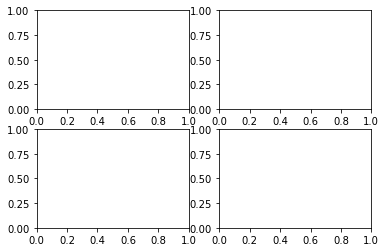

In [5]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(2,2)

In [10]:
help(fig.savefig)


import io
buffer = io.BytesIO()
fig.savefig(buffer, format='png')
buffer.seek(0)
img = tf.image.decode_png(buffer.getvalue(), channels=4)
img = tf.expand_dims(img, 0)

Help on method savefig in module matplotlib.figure:

savefig(fname, *, transparent=None, **kwargs) method of matplotlib.figure.Figure instance
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None, metadata=None)
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    
    fname : str or PathLike or file-like object
        A path, or a Python file-like object, or
        possibly some backend-dependent object such as
        `matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is not set, then the output format is inferred from
        the extension of *fname*, if any, and from :rc:`savefig.format`
        otherwise.  If *format* is set, it determines the output format.
    
        Hence, i